<a href="https://colab.research.google.com/github/fabriziobasso/kaggle/blob/main/Optiver_comp_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OPTIVER COMPETITION SEPT-2023**

## **1.0 Dataset Description**
This dataset contains historic data for the daily ten minute closing auction on the NASDAQ stock exchange. Your challenge is to predict the future price movements of stocks relative to the price future price movement of a synthetic index composed of NASDAQ-listed stocks.

This is a forecasting competition using the time series API. The private leaderboard will be determined using real market data gathered after the submission period closes.

#### **Files**
* **[train/test].csv** The auction data. The test data will be delivered by the API.

* **stock_id** - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
* **date_id** - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
* **imbalance_size** - The amount unmatched at the current reference price (in USD).
* **imbalance_buy_sell_flag** - An indicator reflecting the direction of auction imbalance:
  * buy-side imbalance; 1
  * sell-side imbalance; -1
  * no imbalance; 0
* **reference_price** - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
* **matched_size** - The amount that can be matched at the current reference price (in USD).
* **far_price** - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
* **near_price** - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
* **[bid/ask]_price** - Price of the most competitive buy/sell level in the non-auction book.
* **[bid/ask]_size** - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
* **wap** - The weighted average price in the non-auction book.

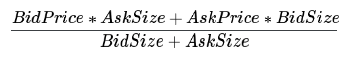

* **seconds_in_bucket** - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
* **target** - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
 * The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
 * The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
 * Where t is the time at the current observation, we can define the target:

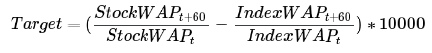

All size related columns are in USD terms.

**All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.**

* **sample_submission**: A valid sample submission, delivered by the API. See this [notebook](https://www.kaggle.com/code/sohier/optiver-2023-basic-submission-demo) for a very simple example of how to use the sample submission.

* **revealed_targets** The first time_id for each date in this file provides the true target values for the entire previous date. All other rows contain mostly null values.

* **public_timeseries_testing_util.py**: An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details.

* **example_test_files** Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API.

* **optiver2023** Files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory.

#### **Relevant Files**

* [Starter Pack v1](https://www.kaggle.com/code/mmmarchetti/the-most-simple-and-dumbest-starter-s-notebook)
* [Discussion](https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion)
* [Starter Pack v1](https://www.kaggle.com/code/iqbalsyahakbar/optiver-a-starter-s-notebook/notebook)  
* [Discord Chat](https://discord.com/channels/1101210829807956100/onboarding)

### 1.1 Install Packages:

In [54]:
%%capture
!pip install tensorflow-addons
#!pip install shap
#!pip install eli5
#!pip install tf-nightly
#!pip install -U scikit-learn==1.2.0
#!pip install catboost
#!pip install haversine
!pip install pytorch-forecasting
!pip install umap-learn
#!pip install reverse_geocoder
#!pip install --upgrade protobuf
!pip install colorama
!pip install imbalanced-learn
!pip install optuna
!pip install optuna-integration
#!pip install pygam
!pip install keras-tuner --upgrade
#!pip install pycaret
!pip install lightning==2.0.1
!pip install keras-nlp

### **1.2 Packages**

In [55]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

In [56]:
#importing modules

import warnings
warnings.filterwarnings('ignore')
import time
t = time.time()

print('Importing started...')

# basic moduele
import os
import numpy as np
import pandas as pd
import re
#from scipy import stats
from random import randint
import random
import math
import os
import gc
import pickle
from glob import glob
from IPython import display as ipd
from tqdm import tqdm
from datetime import datetime
from joblib import dump, load
import sklearn as sk
from imblearn.over_sampling import SMOTE, RandomOverSampler
from functools import partial
import itertools
from itertools import combinations
import IPython
import IPython.display

# visualization moduels
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib_venn import venn2_unweighted
import seaborn as sns
import missingno as msno
import imblearn

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
#sns.set_theme(style="ticks", context="notebook")
sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

# Style Import
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

# preprocessing modules
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     StratifiedKFold,
                                     cross_val_score,
                                     GroupKFold,
                                     GridSearchCV,
                                     RepeatedStratifiedKFold)

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder,
                                   PolynomialFeatures)

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectFromModel


# metrics
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss)


# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  TweedieRegressor,
                                  ARDRegression,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.isotonic import IsotonicRegression

from sklearn.ensemble import (AdaBoostRegressor,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              StackingRegressor,
                              HistGradientBoostingClassifier,
                              ExtraTreesClassifier)

from sklearn.base import BaseEstimator, TransformerMixin

# Other Models
#from pygam import LogisticGAM, s, te
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

#import catboost as cat
#from catboost import CatBoost, CatBoostRegressor
#from catboost import CatBoostClassifier

#from catboost.utils import get_roc_curve

from lightgbm import early_stopping
# check installed version
#import pycaret
warnings.filterwarnings("ignore")


from sklearn.base import clone ## sklearn base models for stacked ensemble model
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

#Interpretiability of the model
#import shap
#import eli5
#from eli5.sklearn import PermutationImportance


## miss
from sklearn.pipeline import (make_pipeline,
                              Pipeline)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from keras.utils import FeatureSpace
import keras_nlp

# Import libraries for Hypertuning
import kerastuner as kt
from kerastuner.tuners import RandomSearch, GridSearch, BayesianOptimization
# Model Tuning tools:
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
%matplotlib inline
SEED = 1984
N_SPLITS = 10

print('Done, All the required modules are imported. Time elapsed: {} sec'.format(time.time()-t))

Importing started...
Done, All the required modules are imported. Time elapsed: 0.010267496109008789 sec


<Figure size 640x480 with 0 Axes>

In [57]:
# Check Versions:
print("CHECK VERSIONS:")
print(f"sns: {sns.__version__}")
print(f"mpl: {mpl.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"scikit-learn: {sk.__version__}")
#print(f"statsmodels: {stm.__version__}")
print(f"missingno: {msno.__version__}")
#print(f"TF-addon: {tfa.__version__}")
print(f"Inbalance_Learning: {imblearn.__version__}")
print(f"XGBoost: {xgb.__version__}")
#print(f"CatBoost: {cat.__version__}")
#print(f"PyCaret: {pycaret.__version__}")

CHECK VERSIONS:
sns: 0.12.2
mpl: 3.7.1
tensorflow: 2.13.0
pandas: 1.5.3
numpy: 1.23.5
scikit-learn: 1.2.2
missingno: 0.5.2
Inbalance_Learning: 0.10.1
XGBoost: 1.7.6


### **2.1 Connect Drives**

Verify System:

In [58]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
/bin/bash: line 1: nvidia-smi: command not found


In [59]:
tf.random.set_seed(0)
np.random.seed(0)
random.seed(42)

SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything(SEED)

Connect to Google Drive:

In [60]:
%%capture
# Connect to Colab:
from google.colab import drive
drive.mount('/content/drive')

In [61]:
folder_data = "/content/drive/MyDrive/kaggle/Optiver_comp_2023/Data/"
models_folders = "/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models"
folders_nn = "/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models/neural_networks/"

list_directories = [folder_data,models_folders,folders_nn]

for path in list_directories:
  try:
      os.mkdir(path)
  except OSError as error:
      print(f"{path} already exists")


os.chdir(folder_data)

/content/drive/MyDrive/kaggle/Optiver_comp_2023/Data/ already exists
/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models already exists
/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models/neural_networks/ already exists


## 2.0 Utility Functions:

### 2.1 Visualization Utilities:

### 2.2 Model Constructions:

## 3.0 Import Data

In [111]:
train = pd.read_csv(r'train.csv').drop('row_id', axis = 1)
train = train.dropna(axis=0, subset=["target"])
revealed_targets = pd.read_csv("example_test_files/revealed_targets.csv")
test = pd.read_csv("example_test_files/test.csv")

In [112]:
train.isna().sum()/len(train)

stock_id                   0.000000
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size             0.000025
imbalance_buy_sell_flag    0.000000
reference_price            0.000025
matched_size               0.000025
far_price                  0.552561
near_price                 0.545466
bid_price                  0.000025
bid_size                   0.000000
ask_price                  0.000025
ask_size                   0.000000
wap                        0.000025
target                     0.000000
time_id                    0.000000
dtype: float64

In [113]:
train.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
dtype: int64

### 3.1 Far Price and Near Price
The analysis reveals that far_price and near_price start printing only after the first 5mins in the closing auciton. All the NaN are therefore replaced with the median value of 1.

In [114]:
fp = train.groupby(["stock_id","time_id","date_id"])["far_price"].agg("first").unstack("stock_id")
fp = fp.reset_index(level=1)
fp.isnull().sum().sum()

2947362

In [115]:
#fp.iloc[:60,:]

In [116]:
values = {"far_price": train.loc[:,"far_price"].median(), "near_price": train.loc[:,"near_price"].median()}
train.fillna(value=values,inplace=True)

In [117]:
train.loc[:,["far_price","near_price"]].describe().T

,count,mean,std,min,25%,50%,75%,max
far_price,5237892.0,1.000702,0.482599,0.000077,0.999883,0.999883,0.999883,437.953100
near_price,5237892.0,0.999785,0.008205,0.786988,0.999889,0.999889,0.999889,1.309732


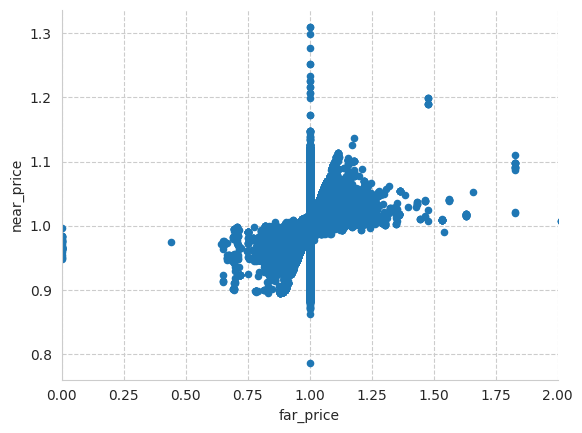

In [118]:
train.loc[:,["far_price","near_price"]].plot(kind="scatter", x="far_price",y="near_price")
plt.xlim(left=0, right=2);

* **Replace extreme Values**

`Far_price` has a number of extreme values. They might be connected to wrong readings or fat-fingers. Extreme values are replaced by interpolated values from a linear regression from `near_price`



In [119]:
X_ = train[(train["far_price"]>=0.5)|(train["far_price"]<=1.5)]["near_price"].values.reshape(-1,1)
y_ = train[(train["far_price"]>=0.5)|(train["far_price"]<=1.5)]["far_price"].values.reshape(-1,1)
print(X_.shape,y_.shape)
lr = LinearRegression()

lr.fit(X=X_,y=y_)
print("Coeff: {}\nIntercept: {}".format(lr.coef_[0][0], lr.intercept_[0]))

(5237892, 1) (5237892, 1)
Coeff: 1.5262149066635804
Intercept: -0.5251849542012421


In [129]:
def replace_farprice(df_, intercept, beta):
  df  = df_.copy()
  arr_0 = df[(df["far_price"]>1.5)|(df["far_price"]<0.5)]["far_price"].values
  arr_1 = df[(df["far_price"]>1.5)|(df["far_price"]<0.5)]["near_price"].values

  arr_1 = intercept + beta*arr_1

  df["far_price"].replace(arr_0, arr_1, inplace=True)

  return df

In [130]:
train = replace_farprice(train, intercept=lr.intercept_[0], beta=lr.coef_[0][0])

In [131]:
lin_x = np.linspace(0,2,50)
lin_y = lr.intercept_+lr.coef_*lin_x

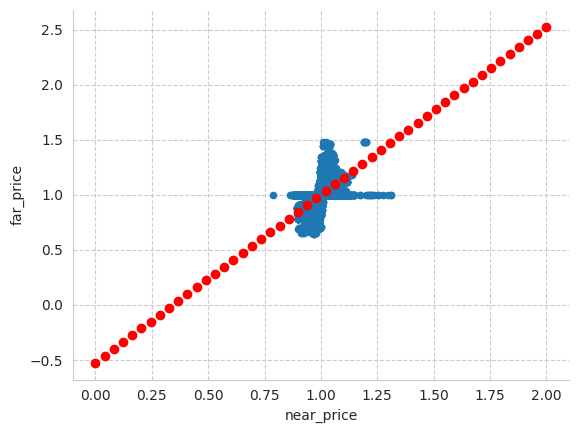

In [132]:
train.loc[:,["far_price","near_price"]].plot(kind="scatter", x="near_price",y="far_price")
plt.scatter(x=lin_x,y=lin_y, c="red")
#plt.ylim(bottom=0, top=2);

90510      126.347940
91616       17.527166
101293      33.234350
121839       1.535378
122031       1.535378
              ...    
4837662      2.042221
4837862      2.042221
4838062      2.042221
4838262      2.042221
5092883      1.657903
Name: far_price, Length: 148, dtype: float64

In [13]:

train["check_near_far"] = train["near_price"].div(train["far_price"])

In [14]:
train[train.check_near_far>2.5].loc[:,"check_near_far"] = 2.3

In [15]:
train[train.check_near_far>2.5].loc[:,"check_near_far"].values

array([ 2339.12135922,  5115.5625    ,   321.75238095,  2358.52427184,
        4204.97435897,  4205.57264957,   794.07154472,  2137.69179601,
        2137.69179601,  3363.70833333,  4018.34567901,  1026.96359743,
       12565.15584416, 12544.61038961,  1158.41224971,  1157.61248528,
        1118.048     ,  1697.11270125,  4420.97209302,  1533.91836735,
         464.94205698,   467.34186383,   467.34186383,  1013.98507463,
        1516.21428571,  1360.31241283,  1360.31241283,  1158.60116279,
        3134.78246753,  3133.78246753,  3133.78246753,  3133.78246753,
        3133.78246753,  3932.49795918,  3934.50204082,  3925.28571429])

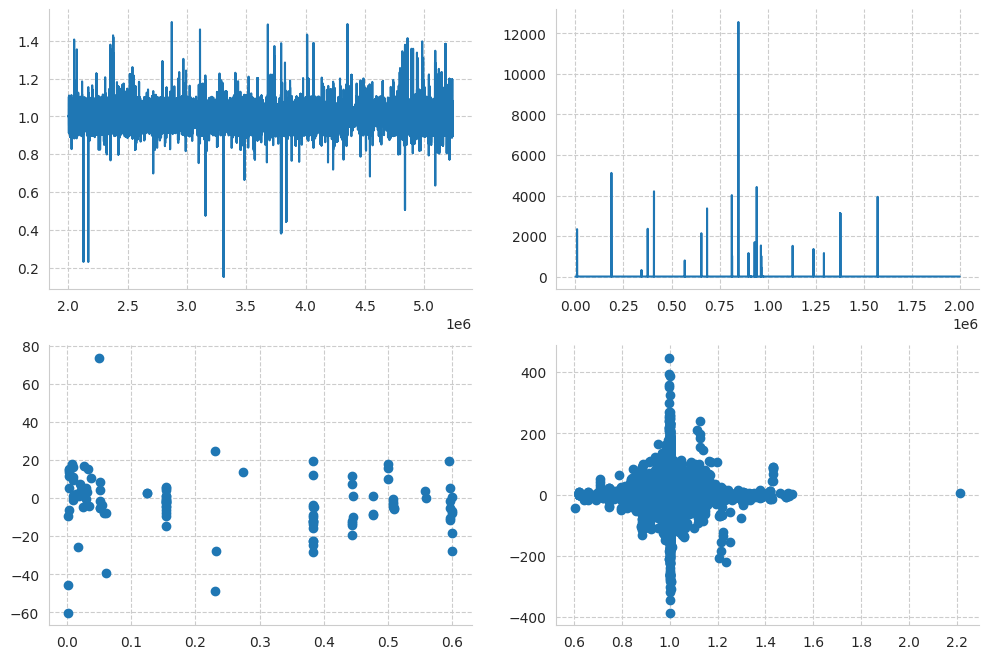

In [16]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax=np.ravel(ax)
verify.loc[2_000_000:,"check_near_far"].plot(ax=ax[0])
verify.loc[:2_000_000,"check_near_far"].plot(ax=ax[1]);
ax[2].scatter(x=verify[(verify.check_near_far<=0.6)]["check_near_far"],y=verify[(verify.check_near_far<=0.6)]["target"]);
ax[3].scatter(x=verify[(verify.check_near_far<=3)&(verify.check_near_far>=0.6)]["check_near_far"],y=verify[(verify.check_near_far<=3)&(verify.check_near_far>=0.6)]["target"]);

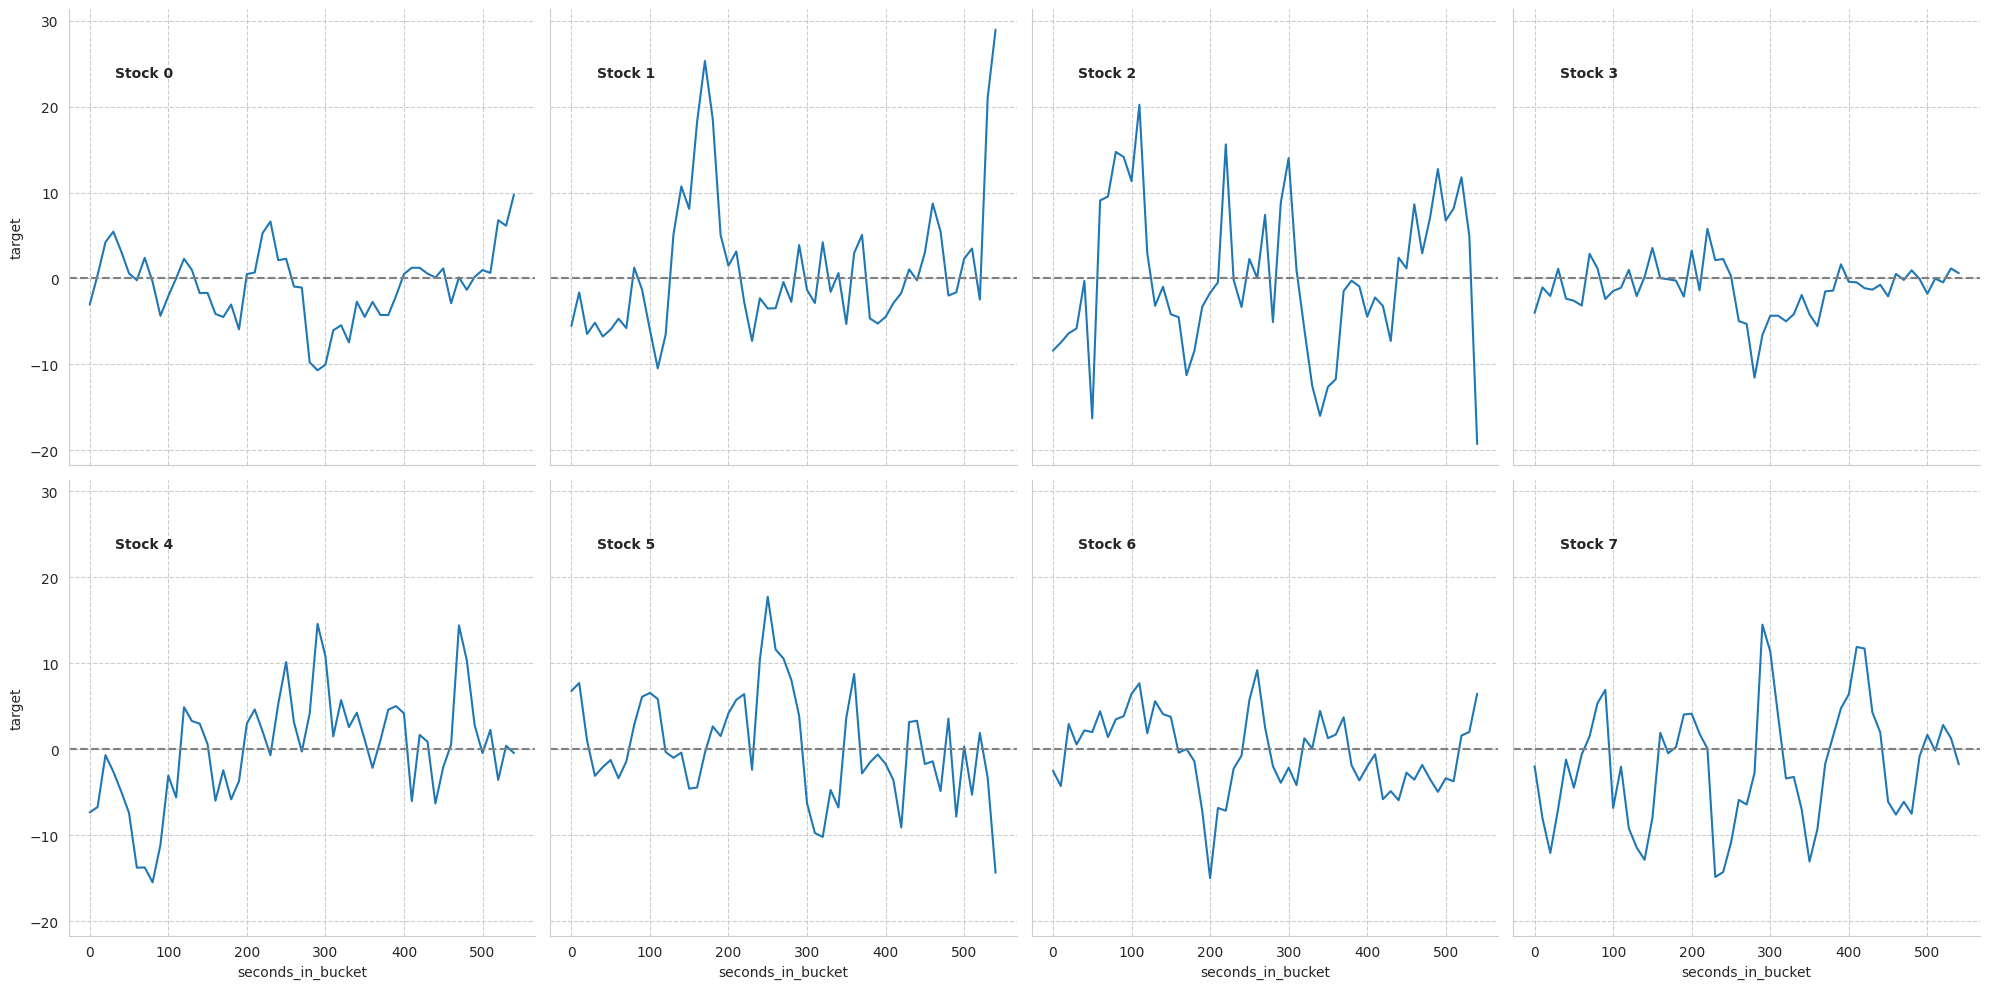

In [17]:
g = sns.relplot(
    data=train.query("date_id == 0 & stock_id < 8"),
    x="seconds_in_bucket",
    y="target",
    kind="line",
    col="stock_id",
    col_wrap=4
)
for stock_id, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(0.1, .85, f"Stock {stock_id}", transform=ax.transAxes, fontweight="bold")
g.set_titles("")
g.refline(y=0)
g.tight_layout()
plt.show()

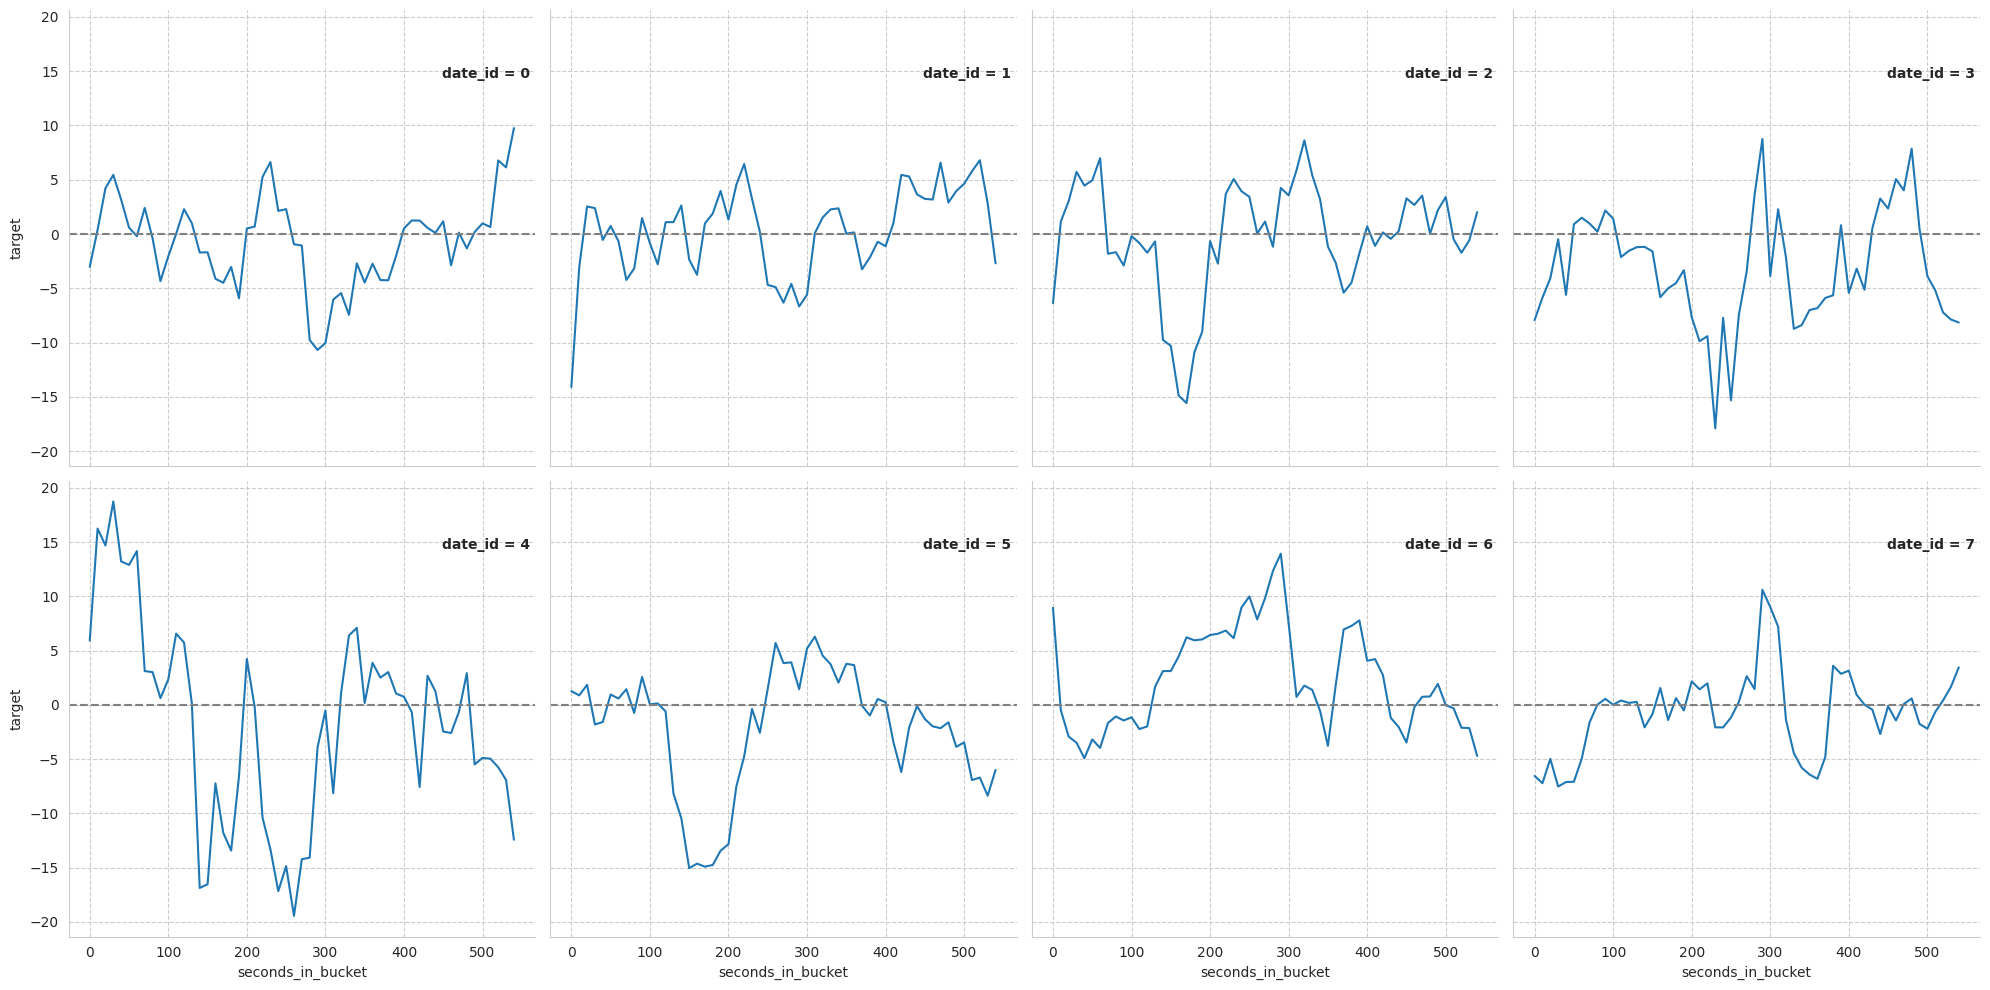

In [18]:
g = sns.relplot(
    data=train.query("stock_id == 0 & date_id < 8"),
    x="seconds_in_bucket",
    y="target",
    kind="line",
    col="date_id",
    col_wrap=4
)
g.refline(y=0)
for date_id, ax in g.axes_dict.items():
    ax.text(.8, .85, f"date_id = {date_id}", transform=ax.transAxes, fontweight="bold")
g.set_titles("")
g.tight_layout()
plt.show()

In [19]:
price_session = train.groupby(["stock_id","time_id","date_id"])["target"].agg("first").unstack("stock_id")
price_session = price_session.reset_index(level=1)
price_session.isnull().sum().sum()

53108

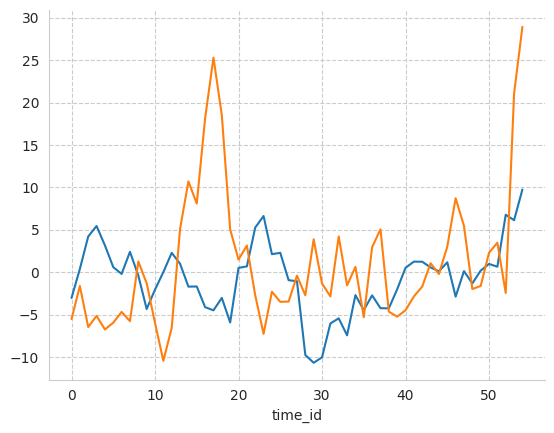

In [20]:
price_session.loc[price_session["date_id"]==0,0].plot()
price_session.loc[price_session["date_id"]==0,1].plot()
plt.grid(linestyle="--")

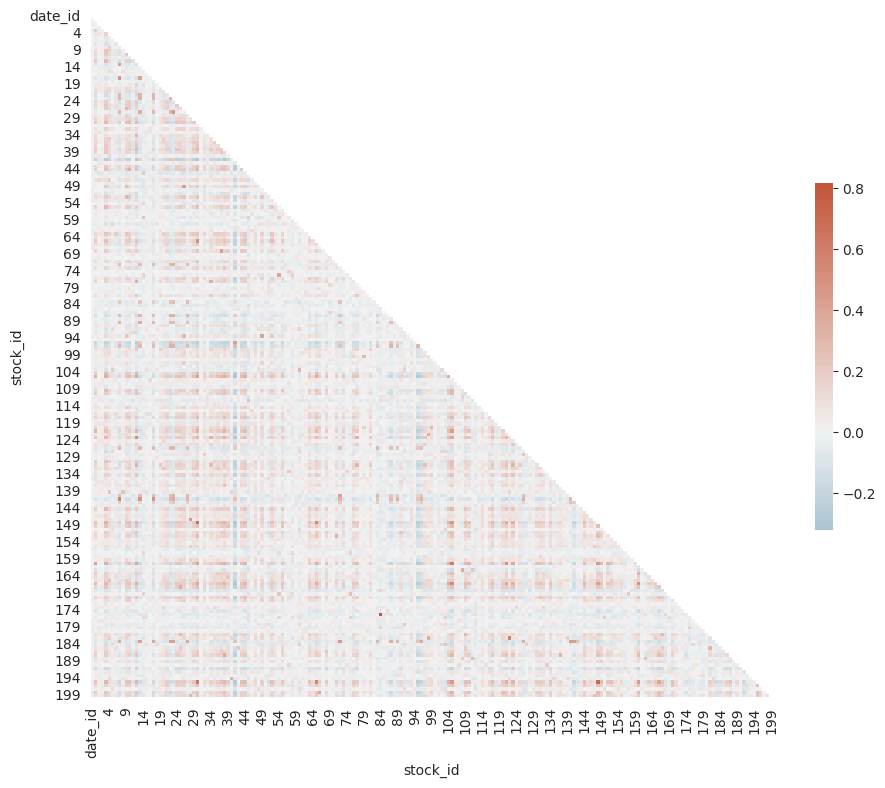

In [21]:
corr = price_session.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=0.0, cbar_kws={"shrink": .5})
plt.grid(linestyle='')

<Axes: xlabel='stock_id', ylabel='stock_id'>

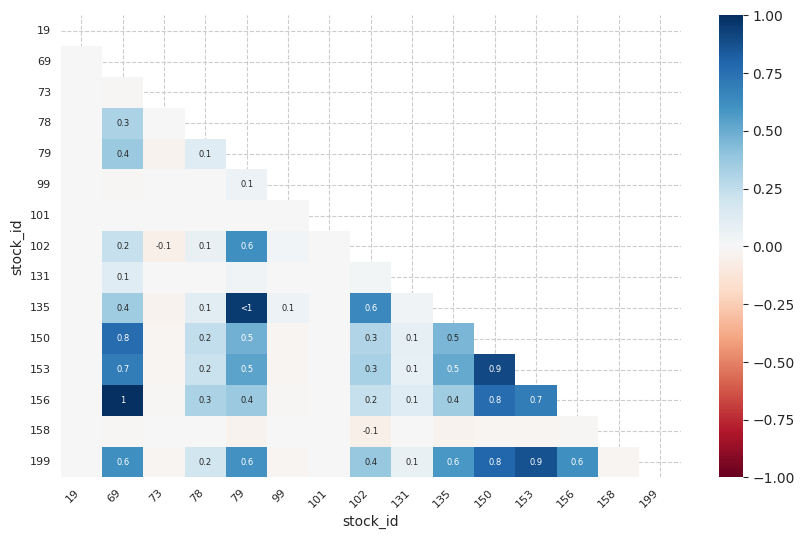

In [22]:
msno.heatmap(price_session, figsize=(10,6), fontsize=8)

<Axes: >

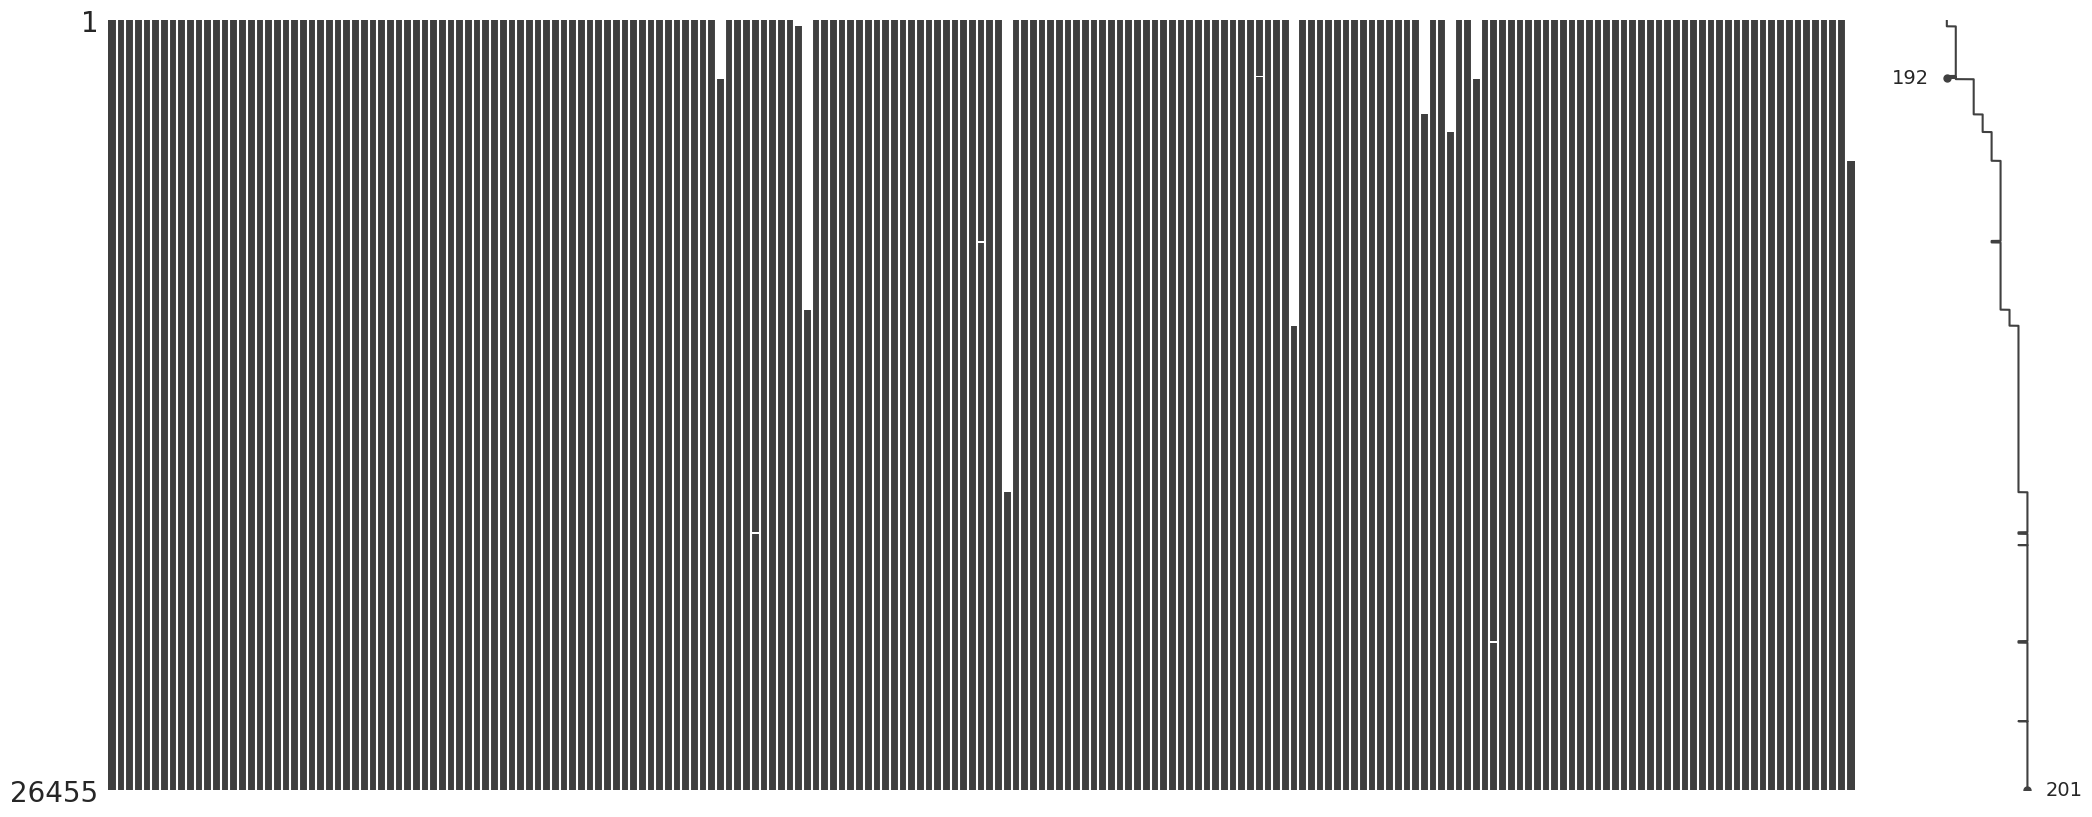

In [23]:
msno.matrix(price_session)

In [24]:
imb_size = train.groupby(["stock_id","time_id","date_id"])["imbalance_size"].agg("first").unstack("stock_id")
imb_size = imb_size.reset_index(level=1)
imb_size.isnull().sum().sum()

53240

<Axes: >

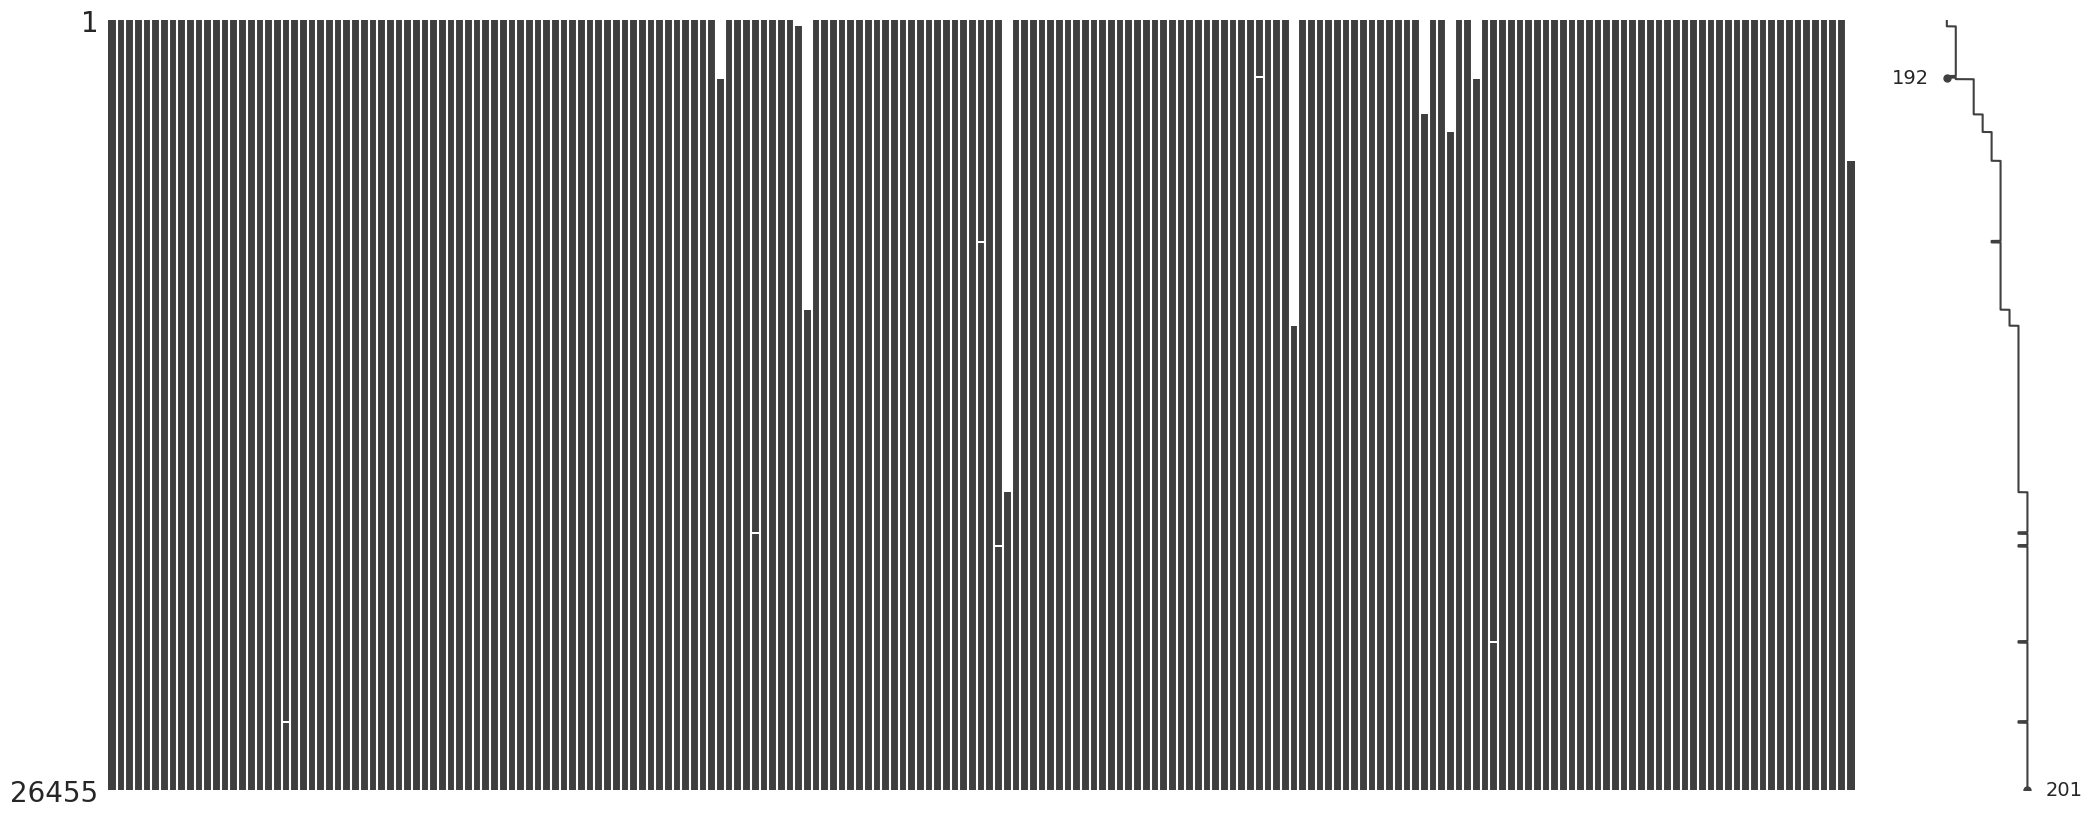

In [25]:
msno.matrix(imb_size)

In [26]:
imb_size.isnull().sum().sum()-price_session.isnull().sum().sum()

132